# Logistic Regression

## Part 1. Loading the Dataset

We loaded the dataset provided from the [UCI ML](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic) repository. We realized that the provided features are not the same as what is documented. The given dataset contains 30 features with three (3) seemingly repeating features. From further research, we realized that these values represent the mean, standard error, and worst values for the given feature. For example, `radius1`, `radius2`, and `radius3` represents the mean radius, radius error, and worst radius, respectively. In this laboratory, we only used the average values. However, contributors may opt to include the other features as well.

In [1]:
!pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo

breast_cancer = fetch_ucirepo(id=17)

# We only used the mean values for each feature.
x = breast_cancer.data.features
x = x.filter(regex='1$')
y = breast_cancer.data.targets

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score


## Part 2. Exploratory Data Analysis

In [4]:
print(str(breast_cancer.metadata.additional_info.variable_info))

1) ID number
2) Diagnosis (M = malignant, B = benign)
3-32)

Ten real-valued features are computed for each cell nucleus:

	a) radius (mean of distances from center to points on the perimeter)
	b) texture (standard deviation of gray-scale values)
	c) perimeter
	d) area
	e) smoothness (local variation in radius lengths)
	f) compactness (perimeter^2 / area - 1.0)
	g) concavity (severity of concave portions of the contour)
	h) concave points (number of concave portions of the contour)
	i) symmetry 
	j) fractal dimension ("coastline approximation" - 1)


In [5]:
x.head()

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


In [6]:
y.head()

,Diagnosis
0,M
1,M
2,M
3,M
4,M


In [7]:
# Replacing the labels from M and B to 1 and 0, respectively
y.loc[:, 'Diagnosis'] = y['Diagnosis'].replace({'M': 1, 'B': 0})
y['Diagnosis'] = y['Diagnosis'].astype(int)
y.head()

<ipython-input-7-a80e76b9ae14>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y.loc[:, 'Diagnosis'] = y['Diagnosis'].replace({'M': 1, 'B': 0})
<ipython-input-7-a80e76b9ae14>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Diagnosis'] = y['Diagnosis'].astype(int)


,Diagnosis
0,1
1,1
2,1
3,1
4,1


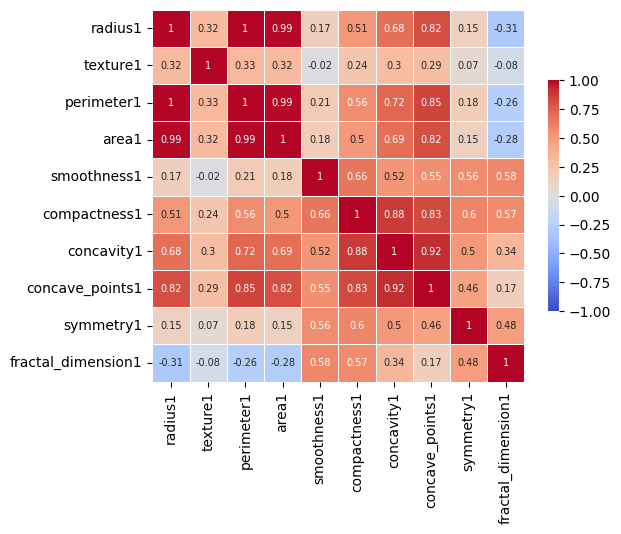

In [8]:
# Generate and visualize the correlation matrix
def heatmap(x):
  corr = x.corr().round(2)
  f, ax = plt.subplots(figsize=(6, 6))
  cmap = sns.diverging_palette(220, 10, as_cmap=True)
  sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, annot_kws={"fontsize":7})
  plt.show()

heatmap(x)

We can see that there seems to be a perfect linearity between perimeter, area, and radius. This is obvious since radius definese both perimeter and area. In avoiding multicollinearity, we need to remove both perimeter and area as it may produce unreliable coefficient estimates. This argument goes the same for concavity, compactness, and concave points. It makes sense to remove concavity adnd concave points to eliminate multicollinearity.

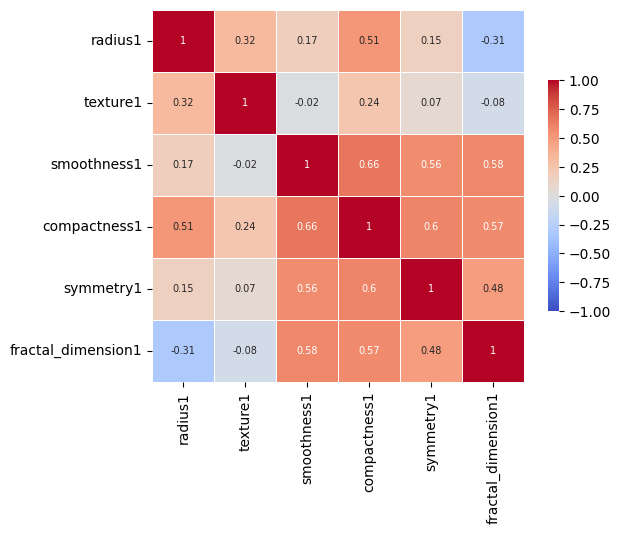

In [9]:
# Visualize the correlation matrix for the chosen features
x = x[['radius1', 'texture1', 'smoothness1', 'compactness1', 'symmetry1', 'fractal_dimension1']]
heatmap(x)

## Part 3: Model Training

### Step 1. Splitting the data

In [10]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=7)

### Step 2. Logistic Regression

In [11]:
# Create a standardScaler and logistic regression pipeline
model = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression())])

# Fit the pipeline to the training set
model.fit(x_train, y_train)

# Use the model to predict the values for the test set
y_pred = model.predict(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Step 3. Model Evaluation

In [12]:
# Determine the training and testing accuracy
print(f"Training Accuracy = {round(model.score(x_train, y_train), 2)}")
print(f"Testing Accuracy = {round(model.score(x_test, y_test), 2)}")

# Show the coefficient values
for key, coef in zip(x.keys(), model.named_steps.model.coef_[0]):
  print(f"{key}: {round(coef, 2)}")

print(f"Intercept: ", model.named_steps.model.intercept_)

Training Accuracy = 0.94
Testing Accuracy = 0.92
radius1: 3.28
texture1: 1.2
smoothness1: 1.05
compactness1: 0.99
symmetry1: 0.5
fractal_dimension1: -0.49
Intercept:  [-0.96137444]


The training accuracy of the model is 94%, with a testing accuracy of 92%. We can see that the most prominent feature is the mean radius with a coefficient of 3.28. Mean texture, smoothness, and compactness contribute approximately similarly to the predictions. Both symmetry and fractal dimensions have fairly low coefficients.

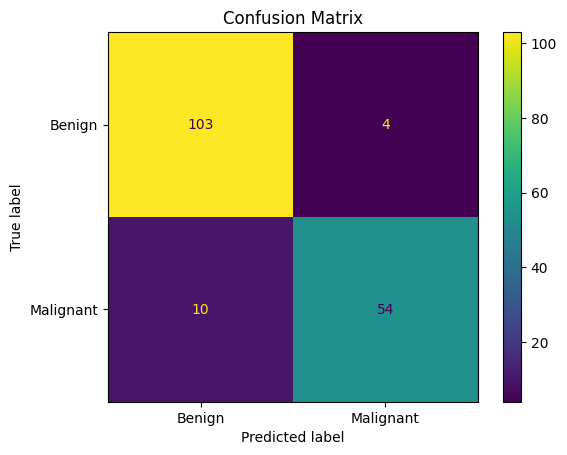

In [13]:
# Create the confusion matrix
cfm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cfm, display_labels = ["Benign", "Malignant"])
cm_display.plot()
plt.title('Confusion Matrix')
plt.show()

In calculating the metrics, we arbitrarily set the benign class as False and the malignant class as True. We can frame this choice by saying that the label defines if the lesion is cancerous or not, or malignant or not.

In [14]:
# Extracting the predictions
TN = cfm[0][0]
FN = cfm[1][0]
TP = cfm[1][1]
FP = cfm[0][1]

# Calculating the model evaluation metrics
precision = TP / (TP + FP)
recall = TP / (TP + FN)
far = FP / (FP + TN)
f1 = 1 / ((1 / precision) + (1 / recall))

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"False Alarm Rate: {far}")
print(f"F1-score: {f1}")

Precision: 0.9310344827586207
Recall: 0.84375
False Alarm Rate: 0.037383177570093455
F1-score: 0.44262295081967207


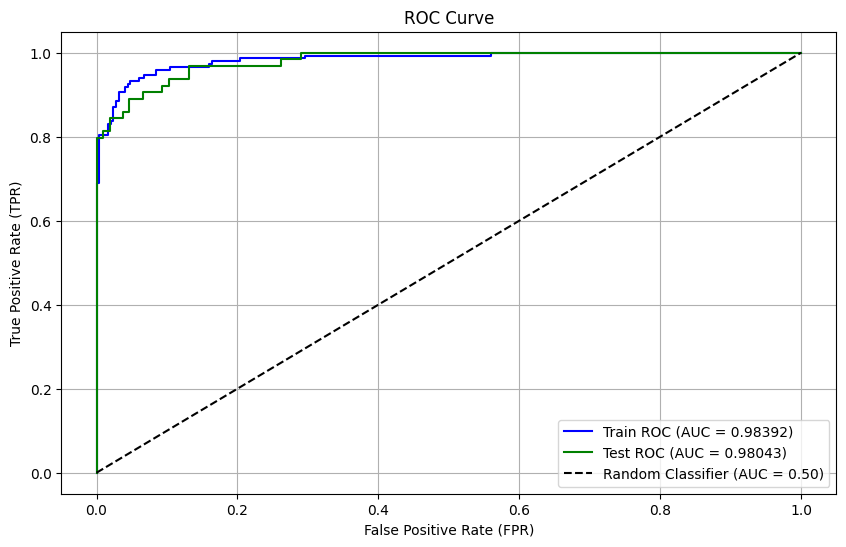

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Use predict_proba to get probabilities
y_train_probs = model.predict_proba(x_train)[:, 1]
y_test_probs = model.predict_proba(x_test)[:, 1]

# Compute ROC curve and AUC for training
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
auc_train = roc_auc_score(y_train, y_train_probs)

# Compute ROC curve and AUC for testing
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)
auc_test = roc_auc_score(y_test, y_test_probs)

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {auc_train:.5f})", color='blue')
plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {auc_test:.5f})", color='green')
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Add labels and legend
plt.title("ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Questions

### Guide Question 1
**What steps are required to remove the "Sample code number" column?**

The provided dataset doesn't contain a `Sample code number` column. However, it suggests that the `Sample code number` is an ID column. You can simply drop it using the `.drop()` method of `pandas.DataFrame`.
### Guide Question 2
**How can the "Class" values be converted into binary (0 and 1) form in Python?**

There are several solutions to arrive with this encoding. According to the document, the corresponding values for benign and malignant are 2 and 4, respectively. A fast way to do is it to reassign the values of the `Diagnosis` column with its value divided by 2, minus 1, simply `Diagnosis = Diagnosis / 2 - 1`
### Guide Question 3
**What is the importance of splitting the dataset into training and testing sets?**

By splitting the dataset into training and testing sets, we essentially create two isolated datasets that can be used for training and testing machine learning models. In this case, we used the training set to fit the data into a logistic regression model.

### Guide Question 4
**Why is it necessary to use the stratify parameter in the train_test_split function?**

The `stratify` parameter allows us to equally split the dataset. This is useful whenever there are different classes that we want to train our model on. In this case, there are benign `B` and malignant `M` classes. Essentially, it provides equality of outcome for both the classes by maintaning the ratios of the training and testing split foor both.

### Guide Question 5
**What is logistic regression, and why is it suitable for this dataset?**

Logistic regression is a machine learning model used for classification tasks. This model is suitable for this dataset because the ground truth labels are categorical variables with two (2) classes. In this case, logistic regression is used for a binary classification task.

### Guide Question 6
**How can the training and testing accuracy of the logistic regression model be calculated?**

The accuracy of a logistic regression model can be calculated with a confusion matrix. The confusion matrix has several derivatives which are used for evaluating the performance of a model. These metrics are precision, recall, accuracy, and F1 score. Moreover, the confusion matrix also provides the necessary information to visualize the Receiver Operating Characteristic (ROC) which is a plot between the true positive rate (TPR) and false positive rate (FPR). Given an ROC curve, a higher area under the curve (AUC) means a better model for all thresholds.

### Guide Question 7
**Which features in the dataset are most influential in determining the tumor status, and how can their importance be assessed?**

The most important feature in determining the tumor status is radius followed by testure, smoothnes, compactness, symmetry, and finally, fractal dimension. The coefficient values are listed below.

radius1: 3.28<br>
texture1: 1.2<br>
smoothness1: 1.05<br>
compactness1: 0.99<br>
symmetry1: 0.5<br>
fractal_dimension1: -0.49<br>

### Guide Question 8
**How is a confusion matrix generated, and what does it represent?**

The confusion matrix can be shown by using the the function `roc_curve()` from `sklearn.metrics`. It essentially plots the actual values and the predicted values and show the false positive errors, false negative errors, true positive results, and true negative results. The confusion matrix serves as a summary statistic for a classification task.

### Guide Question 9
**How are precision, recall, F1-score, and false alarm rate calculated from the confusion matrix?**

Given a confusion matrix, precision, recall, F1-score, and false alarm rate can be calculated as follows:

$$ precision = \frac{TP}{TP+FP} $$
$$ recall = \frac{TP}{TP+FN} $$
$$ F1 = \frac{1}{\frac{1}{TP}+\frac{1}{FP}} $$
$$ FAR = \frac{FP}{FP+TN} $$


### Guide Question 10
**Why are these metrics important for evaluating the performance of a classifier?**

These metrics show the performance of a classification model. The importance of these metrics are largely dependent on the use case. Precision is a good metric for spam filtering, recall is a good metric for medical diagnosis, while F1-score is a good metric for balancing the benefits of both precision and recall. By adjusting the thresholds, a machine learning engineer can prioritize certain metrics that is salient in their use case.

### Guide Question 11
**What is an ROC curve, and how is it plotted for a logistic regression model?**

ROC (Receiver Operating Characteristic) curve is plotted by comparing the true positive rate and false positive rate. This is used to determine the performance of the model across all thresholds. The steeper the ROC curve is, the more performant the model is.

### Guide Question 12
**How is the AUC (Area Under the Curve) calculated, and what does it signify about the model's performance?**

The AUC (Area Under the Curve) is, as its name suggests, the area under the ROC curve. The higher this value, the better the ROC curve is and the better the model's performance.

### Guide Question 13
**How do the training and testing ROC curves compare, and what insights can be derived from this comparison?**

The training ROC has a better curve than that of the test ROC. This means that the performance of the model across all thresholds are less performant when tested on the test set. This is expected for any evaluation metric in machine learning. Moreover, this shows model underfitting or overfitting. In this case, the test ROC didn't deviate too much from the training ROC. If it does, it may mean that the model is underfitted or overfitted to the training data.

### Guide Question 14
**What challenges did you encounter during the preprocessing or model training phases, and how did you address them?**

The significant challenge we faced is preprocessing the data. The provided dataset isn't the same as what is documented in the programming assignment. The features contained three (3) different variations of the same feature. From there, we simply searched the internet and realized that these features are the mean, standard error, and worst value for the feature.

### Guide Question 15
**If the model's performance is not satisfactory, what adjustments could be made to improve it?**

There are several ways we can solve having a model that isn't satisfactory. First, we can use data validation by splitting the data into training, validation, and test sets. We didn't do that in this laboratory because we didn't have any hyperparameter to tune. We can also use regularization techniques like what we did in the previous laboratory such as lasso regression, ridge regression, or elastic net which is the combination of these two.